In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import glob

In [3]:
bg_file_list = glob.glob("/data0/users/bpnachman/anomaly/bigger/processed_lhe*background.txt")
signal_file_list = glob.glob("/data0/users/bpnachman/anomaly/bigger/processed_lhe*signal.txt")

In [4]:
big_bg_path = "/data0/users/bpnachman/anomaly/bigger/processed_background_randomseeds.txt"

In [5]:
big_bg_path

'/data0/users/bpnachman/anomaly/bigger/processed_background_randomseeds.txt'

In [6]:
bg_verybig_list = glob.glob("/data0/users/bpnachman/anomaly/bigger/processed_background_randomseeds_bigger*.txt")

In [7]:
bg_verybig_list = sorted(bg_verybig_list)

In [8]:
bg_verybig_list

['/data0/users/bpnachman/anomaly/bigger/processed_background_randomseeds_bigger1.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_background_randomseeds_bigger2.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_background_randomseeds_bigger3.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_background_randomseeds_bigger4.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_background_randomseeds_bigger5.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_background_randomseeds_bigger6.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_background_randomseeds_bigger7.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_background_randomseeds_bigger8.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_background_randomseeds_bigger9.txt']

In [9]:
test_bg = '/data0/users/bpnachman/anomaly/bigger/processed_background_randomseeds_bigger3.txt'

In [10]:
bg_file_list

['/data0/users/bpnachman/anomaly/bigger/processed_lhe005_background.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_lhe004_background.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_lhe001_background.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_lhe006_background.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_lhe007_background.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_lhe002_background.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_lhe008_background.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_lhe003_background.txt']

In [11]:
signal_file_list

['/data0/users/bpnachman/anomaly/bigger/processed_lhe004_signal.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_lhe005_signal.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_lhe003_signal.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_lhe002_signal.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_lhe006_signal.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_lhe009_signal.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_lhe007_signal.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_lhe001_signal.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_lhe010_signal.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_lhe008_signal.txt']

In [12]:
def parse_file_numparts(file_object, filename):
    all_records = []
    count = 0
    print('Opening ' + filename[-10:])
    for line in file_object:
        if count%100000 == 0:
            print('Parsing line ' + str(count))
            
            
        count += 1
        metadata = line.split("J")[0]
        particles = line.split("P")[1]


        nparticles  = int(len(particles.split())/5) #number of particles
        all_records.append(nparticles)
    return all_records

In [18]:
def parse_file_np(file_object, filename, pad_size):
    padded_part_arrays = []
    truthsqrtshats = []
    count = 0
    print('Opening ' + filename[-10:])
    for line in file_object:
        if count%100000 == 0:
            print('Parsing line ' + str(count))
            
            
        count += 1
        metadata = line.split("J")[0]
        particles = line.split("P")[1]
        
        truthsqrtshat = float(metadata.split()[2])
        if truthsqrtshat < 200 or truthsqrtshat > 500:
            continue
        
        this_record = {}
        particles_list = particles.split()

        #True collision quantities
        truthsqrtshats.append(float(metadata.split()[2])) #energy available for making new particles (electron energy - photon)


        particles_list = particles.split()
        particles_vec = np.array(particles_list).astype('float')
        particles_vec = np.reshape(particles_vec, (-1, 5))
        
        
        # omit index 0
        particles_vec = particles_vec[:,1:]
        # determine how many zero values to pad
        pad_length = pad_size - particles_vec.shape[0]
        #pad
        padded_particles = np.pad(particles_vec, ((0,pad_length),(0,0)))
        
        # check padding
        assert padded_particles.shape == (pad_size, 4)
        # add to list
        padded_part_arrays.append(padded_particles)
    x = np.array(padded_part_arrays)
    print(x.shape)
    return x, np.array(truthsqrtshats)

In [14]:
def parse_file_simple(file_object, filename):
    all_records = []
    count = 0
    print('Opening ' + filename[-10:])
    for line in file_object:
        if count%100000 == 0:
            print('Parsing line ' + str(count))
            
            
        count += 1
        metadata = line.split("J")[0]
        particles = line.split("P")[1]

        this_record = {}

        nparticles  = int(len(particles.split())/5) #number of particles

        #True collision quantities
        this_record['truthsqrtshat'] = float(metadata.split()[2]) #energy available for making new particles (electron energy - photon)

        this_record['nparticles'] = nparticles

        particles = particles.split()
        particles_vec = []
        for i in range(nparticles):
            #order:
            # - index
            # - magnitude of momentum |p| (units of GeV)
            # - pseudorapidity (~polar angle - see e.g. https://en.wikipedia.org/wiki/Pseudorapidity)
            # - azimuthal angle
            # - particle identifier (https://pdg.lbl.gov/2006/reviews/pdf-files/montecarlo-web.pdf)
            particle = particles[i*5:i*5+5]
            particles_vec.append(particle)
            #print(particles[i*5],particles[i*5+1],particles[i*5+2],particles[i*5+3],particles[i*5+4])
        this_record['particles'] = particles_vec
        all_records.append(this_record)
    return all_records

In [15]:
max_nparticles = 282

In [4]:
#"Background only" i.e. no anomalies in this dataset
#myfile = open("/data0/users/bpnachman/anomaly/processed_lhe001_background.txt")

#Want to make new particles with a given mass.  E = mc^2
#Instead electron + electron -> new particle -> stuff we sift through
#electron + electron -> photon + new particle -> stuff



def parse_file(file_object):
    all_records = []
    mymeasuredenergy = []

    count = 0
    for line in file_object:

        metadata = line.split("J")[0]
        eventinfo = line.split("J")[1]
        jets = eventinfo.split("P")[0]
        particles = eventinfo.split("P")[1]

        this_record = {}
        this_record['label'] = count
        count += 1
        eventweight = float(metadata.split()[0])
        this_record['eventweight'] = eventweight #this is the event "weight".  Let's ignoreit for now (we will need it later).
        njets = int(len(jets.split())/11) #number of "jets"

        nparticles  = int(len(particles.split())/5) #number of particles




        #True collision quantities
        this_record['truthcenterofmassenergy'] = float(metadata.split()[1]) #true total energy - should be delta function at 1000 GeV
        this_record['truthsqrtshat'] = float(metadata.split()[2]) #energy available for making new particles (electron energy - photon)
        this_record['truthphotonpT'] = float(metadata.split()[3]) #photon momentum |p| in units of GeV
        this_record['truthphotoneta'] = float(metadata.split()[4]) #photon pseudorapidity (~polar angle - see e.g. https://en.wikipedia.org/wiki/Pseudorapidity)
        this_record['truthphotonphi'] = float(metadata.split()[5]) #photon azimuthal angle

        #Measured collision quantities
        measuredcenterofmassenergy  = float(metadata.split()[6]) #true measured energy - should be noisy version of truthcenterofmassenergy
        this_record['measuredcenterofmassenergy'] = measuredcenterofmassenergy
        this_record['measuredsqrtshat'] = float(metadata.split()[7]) #energy available for making new particles (electron energy - photon)
        this_record['measuredphotonpT'] = float(metadata.split()[8]) #photon momentum |p| in units of GeV
        this_record['measuredphotoneta'] = float(metadata.split()[9]) #photon pseudorapidity (~polar angle - see e.g. https://en.wikipedia.org/wiki/Pseudorapidity)
        this_record['measuredphotonphi'] = float(metadata.split()[10]) #photon azimuthal angle
        this_record['metadata'] = metadata.split()

        mymeasuredenergy+=[measuredcenterofmassenergy]

        this_record['njets'] = njets
        jets = jets.split()
        jets_vec = []
        for i in range(njets):
            jet = np.zeros(11)
            #order:
            # - index
            # - magnitude of momentum |p| (units of GeV)
            # - pseudorapidity (~polar angle - see e.g. https://en.wikipedia.org/wiki/Pseudorapidity)
            # - azimuthal angle
            # - mass (units of GeV/c^2)
            # - bit encoding of the jet "flavor" (not totally sure what the bit means, but will look it up)
            # - 0th angular moment of jet radiation
            # - 1th angular moment of jet radiation
            # - 2th angular moment of jet radiation
            # - 3th angular moment of jet radiation
            # - 4th angular moment of jet radiation
            jet = jets[i*11:i*11+11]
            jets_vec+=[jet]

        this_record['jets']=jets_vec

        this_record['nparticles'] = nparticles

        particles = particles.split()
        particles_vec = []
        for i in range(nparticles):
            particle = np.zeros(5)
            #order:
            # - index
            # - magnitude of momentum |p| (units of GeV)
            # - pseudorapidity (~polar angle - see e.g. https://en.wikipedia.org/wiki/Pseudorapidity)
            # - azimuthal angle
            # - particle identifier (https://pdg.lbl.gov/2006/reviews/pdf-files/montecarlo-web.pdf)
            particle = particles[i*5:i*5+5]
            particles_vec+=[particle]
            #print(particles[i*5],particles[i*5+1],particles[i*5+2],particles[i*5+3],particles[i*5+4])
        this_record['particles'] = particles_vec

        all_records.append(this_record)
    return all_records

In [ ]:
file = open(test_bg)
X_bg , y_bg = parse_file_np(file, test_bg, max_nparticles)

In [31]:
X_bg.shape

(29455, 282, 4)

In [33]:
np.hstack([y_bg, y_bg]).shape

(58910,)

In [32]:
y_bg

array([422.897, 282.393, 383.488, ..., 161.618, 271.558, 342.721])

In [6]:
len(bg_records)
#originalls 1.27M

1280000

In [20]:
a = np.zeros((2, 3, 4))

In [21]:
a.shape

(2, 3, 4)

In [22]:
np.vstack([a,a,a]).shape

(6, 3, 4)

In [23]:
list_of_X_bg = []
list_of_y_bg = []
for filename in bg_verybig_list:
    file = open(filename)
    X_bg, y_bg = parse_file_np(file, filename, max_nparticles)
    list_of_X_bg.append(X_bg)
    list_of_y_bg.append(y_bg)
X_bg = np.vstack(list_of_X_bg)
y_bg = np.hstack(list_of_y_bg)
print(X_bg.shape)
print(y_bg.shape)

Opening igger1.txt
Parsing line 0
Parsing line 100000
Parsing line 200000
Parsing line 300000
Parsing line 400000
Parsing line 500000
Parsing line 600000
Parsing line 700000
Parsing line 800000
Parsing line 900000
Parsing line 1000000
Parsing line 1100000
Parsing line 1200000
Parsing line 1300000
Parsing line 1400000
Parsing line 1500000
Parsing line 1600000
Parsing line 1700000
Parsing line 1800000
Parsing line 1900000
Parsing line 2000000
Parsing line 2100000
Parsing line 2200000
Parsing line 2300000
Parsing line 2400000
Parsing line 2500000
Parsing line 2600000
Parsing line 2700000
(89025, 282, 4)
Opening igger2.txt
Parsing line 0
Parsing line 100000
Parsing line 200000
Parsing line 300000
Parsing line 400000
Parsing line 500000
Parsing line 600000
Parsing line 700000
Parsing line 800000
(26233, 282, 4)
Opening igger3.txt
Parsing line 0
Parsing line 100000
Parsing line 200000
Parsing line 300000
Parsing line 400000
Parsing line 500000
Parsing line 600000
(19192, 282, 4)
Opening igge

In [24]:
list_of_X_sig = []
list_of_y_sig = []
for filename in signal_file_list:
    file = open(filename)
    X_sig, y_sig = parse_file_np(file, filename, max_nparticles)
    list_of_X_sig.append(X_sig)
    list_of_y_sig.append(y_sig)
X_sig = np.vstack(list_of_X_sig)
y_sig = np.hstack(list_of_y_sig)
print(X_sig.shape)
print(y_sig.shape)

Opening signal.txt
Parsing line 0
(9823, 282, 4)
Opening signal.txt
Parsing line 0
(9835, 282, 4)
Opening signal.txt
Parsing line 0
(9845, 282, 4)
Opening signal.txt
Parsing line 0
(9841, 282, 4)
Opening signal.txt
Parsing line 0
(9866, 282, 4)
Opening signal.txt
Parsing line 0
(9834, 282, 4)
Opening signal.txt
Parsing line 0
(9846, 282, 4)
Opening signal.txt
Parsing line 0
(9826, 282, 4)
Opening signal.txt
Parsing line 0
(9822, 282, 4)
Opening signal.txt
Parsing line 0
(9853, 282, 4)
(98391, 282, 4)
(98391,)


In [9]:
max_particles = max(num_bgparticles)
#should be 282
max_particles

282

In [ ]:
1+2

In [14]:
sig_records = []
for filename in signal_file_list:
    file = open(filename)
    sig_records += parse_file(file)

In [15]:
len(sig_records)

100000

In [18]:
# for i in sig_records:
#     i['from_anomaly_data'] = True

In [19]:
# for i in bg_records:
#     i['from_anomaly_data'] = False

In [47]:
# all_records = sig_records[:10000] + bg_records

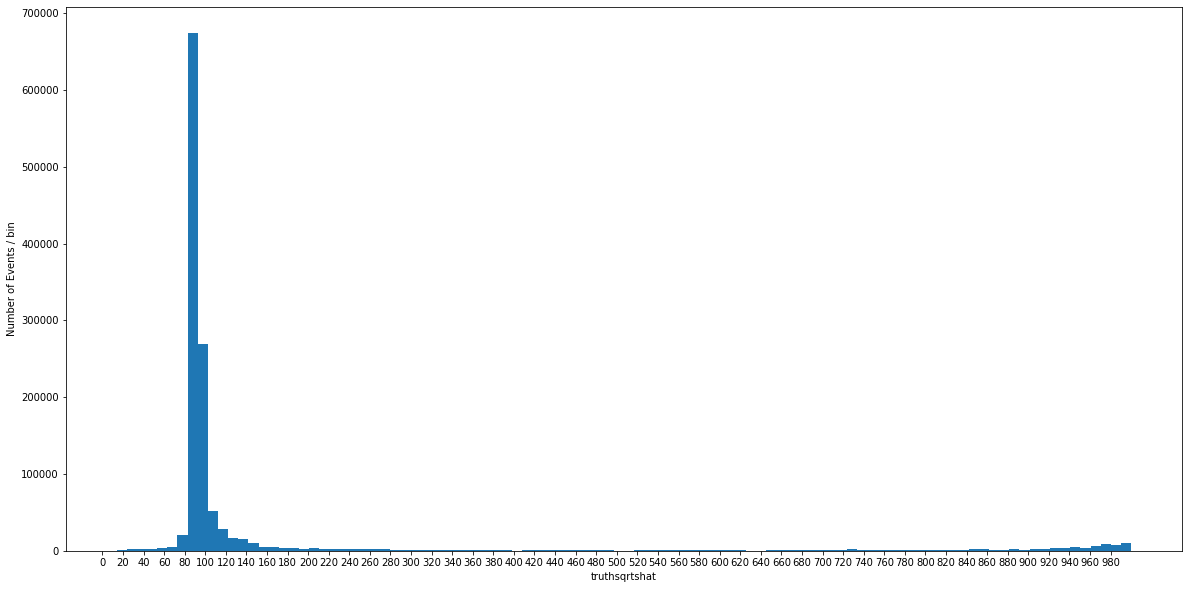

In [29]:
plt.figure(figsize=(20,10))
this_arr = np.array([i['truthsqrtshat'] for i in bg_records])
plt.hist(this_arr, bins=100)
#plt.hist(this_arr, bins=np.logspace(1.5,3,30))
#plt.xscale('log')
plt.xticks(range(0,1000,20))
plt.xlabel("truthsqrtshat")
plt.ylabel("Number of Events / bin")
np.save('training_data/bg_truthsqrtshat', this_arr)

## EFN experimenting

### imports and settings

In [7]:
import energyflow as ef
from energyflow.archs import PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical
from sklearn.metrics import roc_auc_score, roc_curve


Using TensorFlow backend.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/shared_env/l

In [8]:
from sklearn.utils import shuffle

### Divide up the data

In [38]:
import math

(array([7.0800e+02, 1.1924e+04, 3.4707e+04, 3.1045e+04, 1.5564e+04,
        4.6450e+03, 1.1000e+03, 2.5000e+02, 5.2000e+01, 5.0000e+00]),
 array([ 36. ,  51.7,  67.4,  83.1,  98.8, 114.5, 130.2, 145.9, 161.6,
        177.3, 193. ]),
 <a list of 10 Patch objects>)

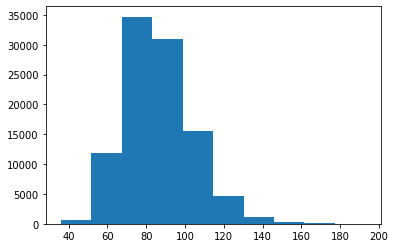

In [99]:
plt.hist([i['nparticles'] for i in sig_records])

(array([1.360e+02, 2.501e+03, 4.060e+03, 2.907e+03, 1.131e+03, 4.240e+02,
        1.510e+02, 4.600e+01, 3.000e+00, 3.000e+00]),
 array([  8. ,  28.3,  48.6,  68.9,  89.2, 109.5, 129.8, 150.1, 170.4,
        190.7, 211. ]),
 <a list of 10 Patch objects>)

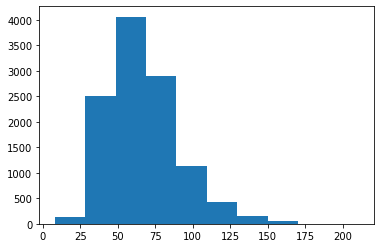

In [100]:
plt.hist([i['nparticles'] for i in bg_records if (i['truthsqrtshat'] > 140 and i['truthsqrtshat'] < 560)])

### Save particles only as X

Save all particles in 3d array. dim 0 = datapoints; dim 1 = particles; dim 2 = particle features.

Particle features have original index 0 omitted. new index 0, 1, 2 are numerical. index 3 is PID

In [9]:
max_bg = max([i['nparticles'] for i in bg_records])

In [16]:
max_sig = max([i['nparticles'] for i in sig_records])

In [17]:
max_nparticles = max((max_bg, max_sig))

In [18]:
"""
Run this cell to save bg particles as X_bg
"""
padded_part_arrays =[]
for record in bg_records:
    # convert to np array
    these_particles = np.array(record['particles']).astype('float')
    # omit index 0
    these_particles = these_particles[:,1:]
    # determine how many zero values to pad
    pad_length = max_nparticles - these_particles.shape[0]
    #pad
    padded_particles = np.pad(these_particles, ((0,pad_length),(0,0)))
    # check padding
    assert padded_particles.shape == (max_nparticles, 4)
    # add to list
    padded_part_arrays.append(padded_particles)
    
all_particle_array = np.array(padded_part_arrays)
X_bg = all_particle_array

In [19]:
X_bg.shape

(1280000, 288, 4)

In [20]:
"""
Run this cell to save X_bg to disk
"""

path = "training_data/X_bg"
np.save(path, X_bg)

In [21]:
y_bg = np.array([i['truthsqrtshat'] for i in bg_records])

In [22]:
"""
Run this cell to save y_bg to disk
"""
path = "training_data/y_bg"

np.save(path, y_bg)

In [23]:
y_bg.shape

(1280000,)

In [24]:
"""
Get X_sig and y_sig
"""
padded_part_arrays =[]
for record in sig_records:
    # convert to np array
    these_particles = np.array(record['particles']).astype('float')
    # omit index 0
    these_particles = these_particles[:,1:]
    # determine how many zero values to pad
    pad_length = max_nparticles - these_particles.shape[0]
    #pad
    padded_particles = np.pad(these_particles, ((0,pad_length),(0,0)))
    # check padding
    assert padded_particles.shape == (max_nparticles, 4)
    # add to list
    padded_part_arrays.append(padded_particles)
    
all_particle_array = np.array(padded_part_arrays)
X_sig = all_particle_array
y_sig = np.array([i['truthsqrtshat'] for i in sig_records])

In [25]:
"""
Run this cell to save X_sig and y_sig to disk
"""

X_sig_path = "training_data/X_sig"
y_sig_path = "training_data/y_sig"
np.save(X_sig_path, X_sig)
np.save(y_sig_path, y_sig)

In [26]:
X_sig.shape

(100000, 288, 4)

In [27]:
y_sig.shape

(100000,)

In [52]:
X.shape

(89999, 260, 4)

### Save jets as Z

In [58]:
all_records[0]['jets']

[['0',
  '189.98',
  '-1.62299',
  '1.02308',
  '89.4432',
  '0',
  '0.429496',
  '0.0397034',
  '0.0308161',
  '0.0261881',
  '0.0196577']]

In [55]:
max_njets = max([i['njets'] for i in all_records])

In [71]:
padded_jet_arrays =[]
for record in all_records:
    # convert to np array
    these_jets = np.array(record['jets']).astype('float')
    # omit index 0
    if len(these_jets) == 0:
        these_jets = np.zeros(11).reshape([1,11])
    these_jets = these_jets[:,1:]
        
    # determine how many zero values to pad
    pad_length = max_njets - these_jets.shape[0]
    #pad
    padded_jets = np.pad(these_jets, ((0,pad_length),(0,0)))
    # check padding
    assert padded_jets.shape == (max_njets, 10)
    # add to list
    padded_jet_arrays.append(padded_jets)
    
all_jet_array = np.array(padded_jet_arrays)
Z = all_jet_array

In [72]:
Z.shape

(79999, 8, 10)

### Save measured truthsqrtshat as y

In [53]:
# y = np.array([i['truthsqrtshat'] for i in all_records])

In [54]:
# y.shape

(89999,)

### Identify signal & side band

In [25]:
side_band_left = 200
side_band_right = 500
signal_left = 300
signal_right = 400
def binary_side_band(y_thing):
    if y_thing >= signal_left and y_thing < signal_right:
        return 1
    elif y_thing >= side_band_left and y_thing < side_band_right:
        return 0
    else:
        return -1


In [26]:
y_binary = np.vectorize(binary_side_band)(y_bg)

In [27]:
np.unique(y_binary,return_counts = True)

(array([0, 1]), array([204986,  83475]))

In [28]:
side_band_indicator = (y_binary == 0)

In [29]:
X_sb = X_bg[side_band_indicator]
y_sb = y_binary[side_band_indicator]

In [30]:
bg_signal_indicator = (y_binary == 1)

In [31]:
X_bgsig = X_bg[bg_signal_indicator]
y_bgsig = y_binary[bg_signal_indicator]

In [32]:
X_sb.shape

(204986, 282, 4)

In [33]:
y_sb.shape

(204986,)

In [34]:
X_bgsig.shape

(83475, 282, 4)

In [35]:
y_bgsig.shape

(83475,)

In [36]:
X_sig.shape

(98391, 282, 4)

In [37]:
y_sig.shape

(98391,)

In [38]:
X_sig_path = "training_data/X_sig"
y_sig_path = "training_data/y_sig"
X_sb_path = "training_data/X_sb"
y_sb_path = "training_data/y_sb"
X_bgsig_path = "training_data/X_bgsig"
y_bgsig_path = "training_data/y_bgsig"
np.save(X_sig_path, X_sig)
np.save(y_sig_path, y_sig)
np.save(X_sb_path, X_sb)
np.save(y_sb_path, y_sb)
np.save(X_bgsig_path, X_bgsig)
np.save(y_bgsig_path, y_bgsig)

### Select signal & side band data points

### Preprocessing

In [69]:
X_bgsignal[:50000].shape

(11049, 267, 4)

In [66]:
X_sideband.shape

(51562, 267, 4)

In [70]:
np.concatenate([X_bgsignal]*3).shape

(33147, 267, 4)

In [68]:
np.concatenate([y_sideband, y_bgsignal]).shape

(62611,)

In [82]:
import math
from sklearn.utils import shuffle

In [79]:
round(2.500000001)

3

In [36]:
def prep_and_shufflesplit_data(anomaly_ratio, size_each = 50000, shuffle_seed = 69,
                               train = 0.7, val = 0.2, test = 0.1, special_test = True):
    
    assert (size_each <= min(X_sideband.shape[0], X_sig.shape[0]))
    
    
    
    
    #how much bg and signal data to take?
    anom_size = round(anomaly_ratio * size_each)
    bg_sig_size = size_each - anom_size
    
    
    # select sideband datapoints
    this_X_sideband = X_sideband[:size_each]
    this_y_sideband = np.zeros(size_each)
    
    # duplicate bgsignal datapoints
    this_X_bgsignal = shuffle(np.copy(X_bgsignal))
    this_y_bgsignal = np.ones(this_X_bgsignal.shape[0])
        
    (this_X_bgsignal, this_X_bgsignal_v, this_X_bgsignal_t,
     this_y_bgsignal, this_y_bgsignal_v, this_y_bgsignal_t) = data_split(this_X_bgsignal, this_y_bgsignal, val=val, test=test)
    
    bg_sig_size_tr = round(bg_sig_size * train)
    
        
    multiplier = math.ceil(bg_sig_size_tr/this_X_bgsignal.shape[0])

    this_X_bgsignal = np.concatenate([this_X_bgsignal] * multiplier)[:bg_sig_size_tr]
    this_y_bgsignal = np.ones(bg_sig_size_tr)

    this_X_bgsignal_v = np.concatenate([this_X_bgsignal_v] * multiplier)[:round(bg_sig_size * val)]
    this_y_bgsignal_v = np.ones(round(bg_sig_size * val))
    
    if special_test:
        test_size_each = round(test * size_each)
        multiplier = math.ceil(test_size_each/len(this_X_bgsignal_t))
        this_X_bgsignal_t = np.concatenate([this_X_bgsignal_t] * multiplier)[:test_size_each]
        this_y_bgsignal_t = None
        
    else:
        test_size_each = None
        this_X_bgsignal_t = np.concatenate([this_X_bgsignal_t] * multiplier)[:round(bg_sig_size * test)]
        this_y_bgsignal_t = np.ones(round(bg_sig_size * test))
        
    print('Size of sigbg (Train, Val, Test):')
    print(this_X_bgsignal.shape, this_X_bgsignal_v.shape, this_X_bgsignal_t.shape)
        
    
#     #select bgsignal datapoints
#     this_X_bgsignal = this_X_bgsignal[:bg_sig_size_tr]
    
#     this_X_bgsignal_v = this_X_bgsignal_v[:round(bg_sig_size * val)]
    
#     this_X_bgsignal_t = this_X_bgsignal_t[:round(bg_sig_size * test)]

    
    #select anomaly datapoints
    this_X_anom = X_sig[:anom_size]
    this_y_anom = np.ones(anom_size)
    
    print('Size of anomalies (pre-splitting):')
    print(this_X_anom.shape)

    
    # only bg_sig has been split. Now, we have to shuffle then split the others.
    this_X = np.concatenate([this_X_sideband, this_X_anom])
    this_y = np.concatenate([this_y_sideband, this_y_anom])
    
    assert this_X.shape[0] == this_y.shape[0]
    this_X, this_y = shuffle(this_X, this_y, random_state = shuffle_seed)
    
    (this_X_train, this_X_val, this_X_test,
     this_y_train, this_y_val, this_y_test) = data_split(this_X, this_y, val=val, test=test)
    
    # make sure there is enough real anomalies to do the special test
    if special_test:
        assert len(X_sig) > anom_size + test_size_each
        X_special_negative = this_X_bgsignal_t
        X_special_positive = X_sig[anom_size:anom_size + test_size_each]
        assert X_special_negative.shape == X_special_positive.shape
        y_special_negative = np.zeros(test_size_each)
        y_special_positive = np.ones(test_size_each)
        
    
    # now, we can add the bg_sig to the rest of the data and shuffle again
    X_train, y_train = shuffle(np.concatenate([this_X_train, this_X_bgsignal]),
                               np.concatenate([this_y_train, this_y_bgsignal]),
                              random_state = shuffle_seed)
    X_val, y_val = shuffle(np.concatenate([this_X_val, this_X_bgsignal_v]),
                               np.concatenate([this_y_val, this_y_bgsignal_v]),
                              random_state = shuffle_seed)
    
    if special_test:
        X_test, y_test = shuffle(np.concatenate([X_special_negative, X_special_positive]),
                                   np.concatenate([y_special_negative, y_special_positive]),
                                  random_state = shuffle_seed)
    else:    
        X_test, y_test = shuffle(np.concatenate([this_X_test, this_X_bgsignal_t]),
                                   np.concatenate([this_y_test, this_y_bgsignal_t]),
                                  random_state = shuffle_seed)
    
    # Centre and normalize all the Xs
    for x in X_train:
        mask = x[:,0] > 0
        yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
        x[mask,1:3] -= yphi_avg
        x[mask,0] /= x[:,0].sum()
    for x in X_val:
        mask = x[:,0] > 0
        yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
        x[mask,1:3] -= yphi_avg
        x[mask,0] /= x[:,0].sum()
    for x in X_test:
        mask = x[:,0] > 0
        yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
        x[mask,1:3] -= yphi_avg
        x[mask,0] /= x[:,0].sum()
    
    # remap PIDs for all the Xs
    remap_pids(X_train, pid_i=3)
    remap_pids(X_val, pid_i=3)
    remap_pids(X_test, pid_i=3)
    
    # change Y to categorical Matrix
    Y_train = to_categorical(y_train, num_classes=2)
    Y_val = to_categorical(y_val, num_classes=2)
    Y_test = to_categorical(y_test, num_classes=2)
    
    print('Training set size, distribution:')
    print(X_train.shape)
    print(np.unique(y_train,return_counts = True))
    print('Validations set size, distribution:')
    print(X_val.shape)
    print(np.unique(y_val,return_counts = True))
    print('Test set size, distribution:')
    print(X_test.shape)
    print(np.unique(y_test,return_counts = True))
    
    return X_train, X_val, X_test, Y_train,Y_val,Y_test
    

In [52]:
def prep_and_shufflesplit_data_simple(size_each = 50000, shuffle_seed = 69,
                               train = 0.7, val = 0.2, test = 0.1, special_test = False):
    
    
    # select sideband datapoints
    this_X_sideband = X_sideband[:size_each]
    this_y_sideband = np.zeros(size_each)
    
    
    #select anomaly datapoints
    this_X_anom = X_sig[:size_each]
    this_y_anom = np.ones(size_each)
    
    print('Size of anomalies (pre-splitting):')
    print(this_X_anom.shape)

    
    this_X = np.concatenate([this_X_sideband, this_X_anom])
    this_y = np.concatenate([this_y_sideband, this_y_anom])
    
    assert this_X.shape[0] == this_y.shape[0]
    this_X, this_y = shuffle(this_X, this_y, random_state = shuffle_seed)
    
    
    # Centre and normalize all the Xs
    for x in this_X:
        mask = x[:,0] > 0
        yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
        x[mask,1:3] -= yphi_avg
        x[mask,0] /= x[:,0].sum()
    
    
    remap_pids(this_X, pid_i=3)
    this_Y = to_categorical(this_y, num_classes=2)

    (X_train, X_val, X_test,
     Y_train, Y_val, Y_test) = data_split(this_X, this_Y, val=val, test=test)
    
    
    
    return X_train, X_val, X_test, Y_train,Y_val,Y_test
    

In [39]:
X_train, X_val, X_test, Y_train,Y_val,Y_test = prep_and_shufflesplit_data(0.1)

Size of sigbg (Train, Val, Test):
(31500, 288, 4) (9000, 288, 4) (5000, 288, 4)
Size of anomalies (pre-splitting):
(5000, 288, 4)
Training set size, distribution:
(70000, 288, 4)
(array([0., 1.]), array([34975, 35025]))
Validations set size, distribution:
(20000, 288, 4)
(array([0., 1.]), array([10007,  9993]))
Test set size, distribution:
(10000, 288, 4)
(array([0., 1.]), array([5000, 5000]))


In [66]:
# train, val, test = 18000, 2000, 1186
# use_pids = True


In [67]:
# # center and normalize
# X_normalized = np.copy(X_shuffled)
# for x in X_normalized:
#     mask = x[:,0] > 0
#     yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
#     x[mask,1:3] -= yphi_avg
#     x[mask,0] /= x[:,0].sum()


In [68]:
# # handle particle id channel
# if use_pids:
#     remap_pids(X_normalized, pid_i=3)
# else:
#     X_normalized = X_normalized[:,:,:3]

In [69]:
# categorize y
# Y = to_categorical(y_shuffled, num_classes=2)

In [70]:
# # do train/val/test split 
# (X_train, X_val, X_test,
#  Y_train, Y_val, Y_test) = data_split(X_normalized, Y, val=val, test=test)

### Building the model

In [81]:
Phi_sizes, F_sizes = (20, 20, 20), (20,20,20)
num_epoch = 10
batch_size = 10

In [40]:
def train_models(X_train, X_val, X_test, Y_train,Y_val,Y_test):
    model = PFN(input_dim=X_train.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)
    history = model.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)
    Y_predict = model.predict(X_test)
    
    return (history, Y_test, Y_predict, model)
    

In [138]:
all_results = []

In [43]:
#result_1
result_1 = train_models(X_train, X_val, X_test, Y_train,Y_val,Y_test)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 10)     50          input[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, 10)     0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 10)     110         activation_1[0][0]               
__________________________________________________________________________________________________
activation

KeyboardInterrupt: 

In [53]:
#result 3
X_train, X_val, X_test, Y_train,Y_val,Y_test = prep_and_shufflesplit_data_simple()
result_3 = train_models(X_train, X_val, X_test, Y_train,Y_val,Y_test)

Size of anomalies (pre-splitting):
(50000, 288, 4)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 10)     50          input[0][0]                      
__________________________________________________________________________________________________
activation_13 (Activation)      (None, None, 10)     0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 10)     110         activation_13[0][0]              
__________________________________________________________

In [83]:
#result_5
X_train, X_val, X_test, Y_train,Y_val,Y_test = prep_and_shufflesplit_data(0.6,special_test = True)
result_5 = train_models(X_train, X_val, X_test, Y_train,Y_val,Y_test)

Size of sigbg (Train, Val, Test):
(14000, 288, 4) (4000, 288, 4) (5000, 288, 4)
Size of anomalies (pre-splitting):
(30000, 288, 4)
Training set size, distribution:
(70000, 288, 4)
(array([0., 1.]), array([35021, 34979]))
Validations set size, distribution:
(20000, 288, 4)
(array([0., 1.]), array([ 9999, 10001]))
Test set size, distribution:
(10000, 288, 4)
(array([0., 1.]), array([5000, 5000]))
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 20)     100         input[0][0]                      
__________________________________________________________________________________________________
activati

In [54]:
#result_2
X_train, X_val, X_test, Y_train,Y_val,Y_test = prep_and_shufflesplit_data(0.95,special_test = True)
result_2 = train_models(X_train, X_val, X_test, Y_train,Y_val,Y_test)

Size of sigbg (Train, Val, Test):
(1750, 288, 4) (500, 288, 4) (5000, 288, 4)
Size of anomalies (pre-splitting):
(47500, 288, 4)
Training set size, distribution:
(70000, 288, 4)
(array([0., 1.]), array([35098, 34902]))
Validations set size, distribution:
(20000, 288, 4)
(array([0., 1.]), array([ 9971, 10029]))
Test set size, distribution:
(10000, 288, 4)
(array([0., 1.]), array([5000, 5000]))
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 10)     50          input[0][0]                      
__________________________________________________________________________________________________
activation

In [215]:
all_results[-1]

(<keras.callbacks.History at 0x7fd54617edd8>,
 array([[0., 1.],
        [0., 1.],
        [1., 0.],
        ...,
        [0., 1.],
        [1., 0.],
        [0., 1.]]),
 array([[3.4478795e-02, 9.6552128e-01],
        [9.2460066e-01, 7.5399265e-02],
        [2.5347410e-02, 9.7465265e-01],
        ...,
        [4.8510003e-05, 9.9995148e-01],
        [6.8398928e-03, 9.9316013e-01],
        [7.8961992e-01, 2.1038003e-01]], dtype=float32))

In [166]:
#result 8
X_train, X_val, X_test, Y_train,Y_val,Y_test = prep_and_shufflesplit_data(0,special_test = True)
result_8 = train_models(X_train, X_val, X_test, Y_train,Y_val,Y_test)

Size of sigbg (Train, Val, Test):
(35000, 267, 4) (10000, 267, 4) (5000, 267, 4)
Size of anomalies (pre-splitting):
(0, 267, 4)
Training set size, distribution:
(70000, 267, 4)
(array([0., 1.]), array([35000, 35000]))
Validations set size, distribution:
(20000, 267, 4)
(array([0., 1.]), array([10000, 10000]))
Test set size, distribution:
(10000, 267, 4)
(array([0., 1.]), array([5000, 5000]))
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 10)     50          input[0][0]                      
__________________________________________________________________________________________________
activation_

In [ ]:
1+1

In [141]:
X_train, X_val, X_test, Y_train,Y_val,Y_test = prep_and_shufflesplit_data(0.0005)
all_results.append(train_models(X_train, X_val, X_test, Y_train,Y_val,Y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 10)     50          input[0][0]                      
__________________________________________________________________________________________________
activation_25 (Activation)      (None, None, 10)     0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 10)     110         activation_25[0][0]              
__________________________________________________________________________________________________
activation

In [142]:
X_train, X_val, X_test, Y_train,Y_val,Y_test = prep_and_shufflesplit_data(0.00005)
all_results.append(train_models(X_train, X_val, X_test, Y_train,Y_val,Y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 10)     50          input[0][0]                      
__________________________________________________________________________________________________
activation_31 (Activation)      (None, None, 10)     0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 10)     110         activation_31[0][0]              
__________________________________________________________________________________________________
activation

In [143]:
X_train, X_val, X_test, Y_train,Y_val,Y_test = prep_and_shufflesplit_data(0)
all_results.append(train_models(X_train, X_val, X_test, Y_train,Y_val,Y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 10)     50          input[0][0]                      
__________________________________________________________________________________________________
activation_37 (Activation)      (None, None, 10)     0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 10)     110         activation_37[0][0]              
__________________________________________________________________________________________________
activation

In [ ]:
X_train, X_val, X_test, Y_train,Y_val,Y_test = prep_and_shufflesplit_data(0)
all_results.append(train_models(X_train, X_val, X_test, Y_train,Y_val,Y_test))

In [145]:
0.00005

5e-05

In [150]:
test_arr = np.array([[1,0],[1,0],[0,1]])

In [151]:
np.unique(test_arr,return_counts = True)

(array([0, 1]), array([3, 3]))

In [144]:
1/50000

2e-05

In [75]:
# # build architecture
# pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 10)     50          input[0][0]                      
__________________________________________________________________________________________________
activation_8 (Activation)       (None, None, 10)     0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 10)     110         activation_8[0][0]               
__________________________________________________________________________________________________
activation

### Training

In [124]:
import sklearn

In [84]:
Y_test = np.copy(result_5[1])
Y_predict = np.copy(result_5[2])

In [85]:
median = np.median(Y_predict[:,1:])

In [86]:
median

0.9989644

In [87]:
Y_test

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [88]:
Y_predict

array([[6.8774486e-01, 3.1225520e-01],
       [1.4887226e-04, 9.9985111e-01],
       [4.8443042e-02, 9.5155692e-01],
       ...,
       [3.4017629e-13, 1.0000000e+00],
       [5.2599201e-04, 9.9947399e-01],
       [5.9704450e-03, 9.9402952e-01]], dtype=float32)

In [61]:
import sklearn

In [89]:
sklearn.metrics.accuracy_score(Y_test[:,1:], (Y_predict[:,1:]*2).astype(int),normalize=True, sample_weight=None)

0.3998

In [62]:
roc_curve = sklearn.metrics.roc_curve(Y_test[:,1:], Y_predict[:,1:])

Text(0.5, 1.0, 'ROC curve')

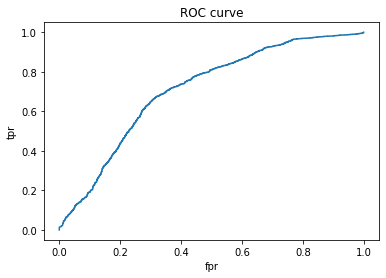

In [63]:
plt.plot(roc_curve[0],roc_curve[1])
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')

In [31]:
#Later for ML: https://energyflow.network/examples/